In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


In [2]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Loading the Data

In [3]:
# Load the data
train_df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test_df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

In [4]:
pd.set_option('display.max_columns', None)

# Exploratory Data Analysis (EDA)

In [5]:
train_df.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,1.0,0385,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,1.0,0906 0352 0371 0446 1822 0344 0416 0417,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,2.0,0329 1202,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,1.0,0329 1300,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,1.0,0416 0945 1822 0400 0417 0344,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [6]:
test_df.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description
0,1500 LEIGHTON AV,NaN,34.0128,-118.3045,03/03/2020 12:00:00 AM,03/03/2020 12:00:00 AM,2000.0,3.0,Southwest,376.0,2.0,0416 1241 1243 1813 1821 2000,28.0,F,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont
1,100 S NORMANDIE AV,NaN,34.0726,-118.3029,06/01/2020 12:00:00 AM,04/25/2020 12:00:00 AM,1700.0,20.0,Olympic,2014.0,1.0,0344 0394,26.0,M,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont
2,300 E 111TH ST,NaN,33.9348,-118.2695,08/28/2020 12:00:00 AM,08/27/2020 12:00:00 AM,900.0,18.0,Southeast,1844.0,2.0,1822 0701 1914 0355 1202 0100,62.0,F,B,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont
3,1300 S LA BREA AV,NaN,34.0497,-118.3442,12/23/2020 12:00:00 AM,12/03/2020 12:00:00 AM,2200.0,7.0,Wilshire,765.0,1.0,NaN,0.0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont
4,11000 MORRISON ST,NaN,34.1611,-118.3704,08/30/2020 12:00:00 AM,08/29/2020 12:00:00 AM,130.0,15.0,N Hollywood,1555.0,2.0,1501,37.0,F,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other


In [7]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

(None, None)

In [8]:
train_df.describe(), test_df.describe()

(           Latitude     Longitude  Time_Occurred       Area_ID  \
 count  20000.000000  20000.000000   20000.000000  20000.000000   
 mean      33.940704   -117.893072    1352.380350     10.834250   
 std        2.126810      7.377726     646.100291      6.033166   
 min        0.000000   -118.663400       1.000000      1.000000   
 25%       34.009200   -118.429700     930.000000      6.000000   
 50%       34.058700   -118.323000    1430.000000     11.000000   
 75%       34.165025   -118.274400    1900.000000     16.000000   
 max       34.328100      0.000000    2359.000000     21.000000   
 
        Reporting_District_no      Part 1-2    Victim_Age  Premise_Code  \
 count           20000.000000  20000.000000  20000.000000  20000.000000   
 mean             1129.599200      1.418150     30.135000    297.176950   
 std               603.330519      0.493267     21.863645    212.007298   
 min               101.000000      1.000000     -2.000000    101.000000   
 25%               6

<Axes: >

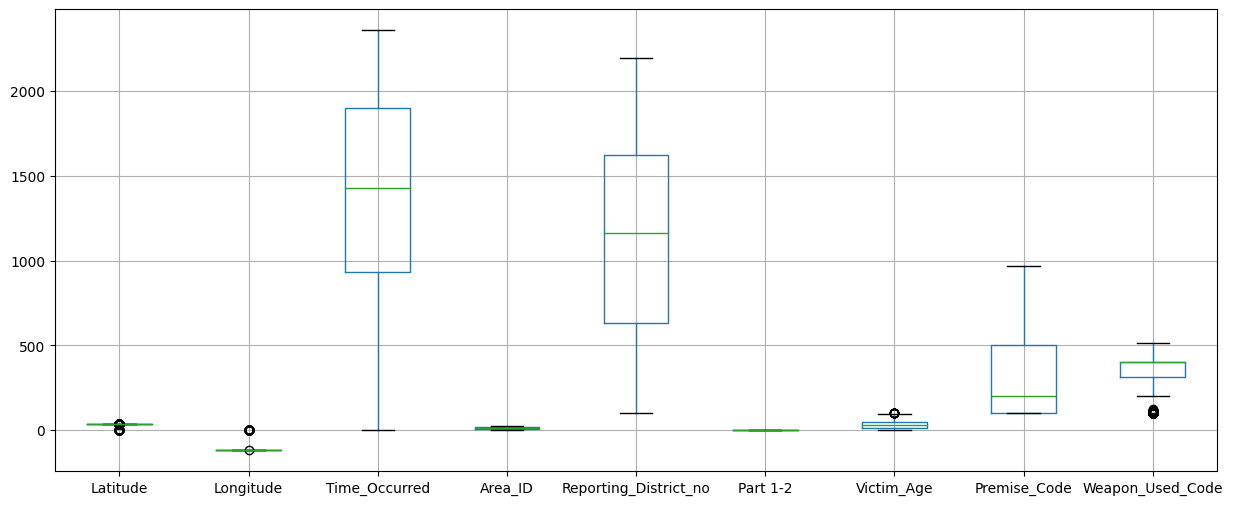

In [9]:
train_df.boxplot(figsize=(15, 6))

In [10]:
train_df.nunique(), test_df.nunique()

(Location                 12399
 Cross_Street              1495
 Latitude                  3622
 Longitude                 3578
 Date_Reported              811
 Date_Occurred              366
 Time_Occurred              996
 Area_ID                     21
 Area_Name                   21
 Reporting_District_no     1120
 Part 1-2                     2
 Modus_Operandi           10489
 Victim_Age                 100
 Victim_Sex                   4
 Victim_Descent              17
 Premise_Code               217
 Premise_Description        216
 Weapon_Used_Code            57
 Weapon_Description          57
 Status                       5
 Status_Description           5
 Crime_Category               6
 dtype: int64,
 Location                 4165
 Cross_Street              547
 Latitude                 2141
 Longitude                2213
 Date_Reported             514
 Date_Occurred             366
 Time_Occurred             517
 Area_ID                    21
 Area_Name                  21
 R

In [11]:
# Check for missing values in the training data
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())


Missing Values in Training Data:
Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64


In [12]:
# Check for missing values in the testing data
print("\nMissing Values in Training Data:")
print(test_df.isnull().sum())


Missing Values in Training Data:
Location                    0
Cross_Street             4190
Latitude                    0
Longitude                   0
Date_Reported               0
Date_Occurred               0
Time_Occurred               0
Area_ID                     0
Area_Name                   0
Reporting_District_no       0
Part 1-2                    0
Modus_Operandi            684
Victim_Age                  0
Victim_Sex                643
Victim_Descent            643
Premise_Code                0
Premise_Description         1
Weapon_Used_Code         3153
Weapon_Description       3153
Status                      0
Status_Description          0
dtype: int64



Distribution of Numerical Features:


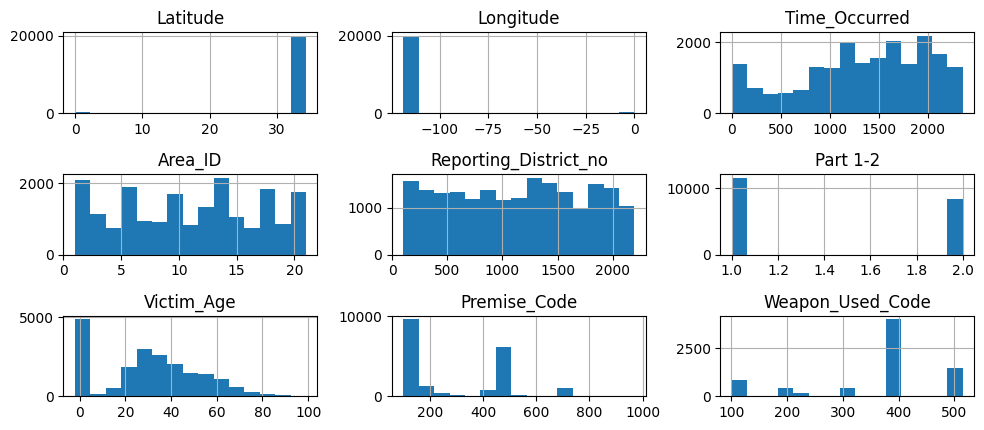

In [13]:
# Distribution of numerical features
numeric_features = train_df.select_dtypes(exclude=["object"]).columns

print("\nDistribution of Numerical Features:")
train_df[numeric_features].describe()


# Plot histograms for numerical features
train_df[numeric_features].hist(bins=15, figsize=(10, 7), layout=(5, 3))
plt.tight_layout()
plt.show()

<Axes: >

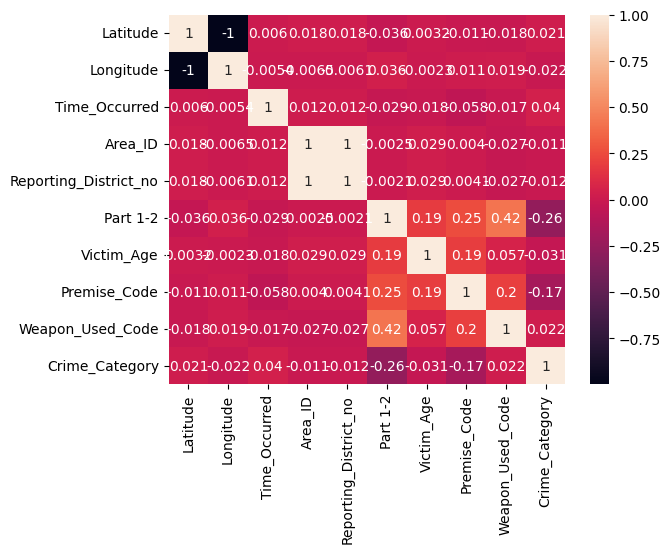

In [14]:
corr_df = train_df.copy()
label_encoder = LabelEncoder()
corr_df['Crime_Category'] = label_encoder.fit_transform(corr_df['Crime_Category'])
numeric_features = corr_df.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(corr_df[numeric_features].corr(), annot=True)

In [15]:
# Analyze categorical features
categorical_features = train_df.select_dtypes(include=["object"]).columns
print(categorical_features)

Index(['Location', 'Cross_Street', 'Date_Reported', 'Date_Occurred',
       'Area_Name', 'Modus_Operandi', 'Victim_Sex', 'Victim_Descent',
       'Premise_Description', 'Weapon_Description', 'Status',
       'Status_Description', 'Crime_Category'],
      dtype='object')


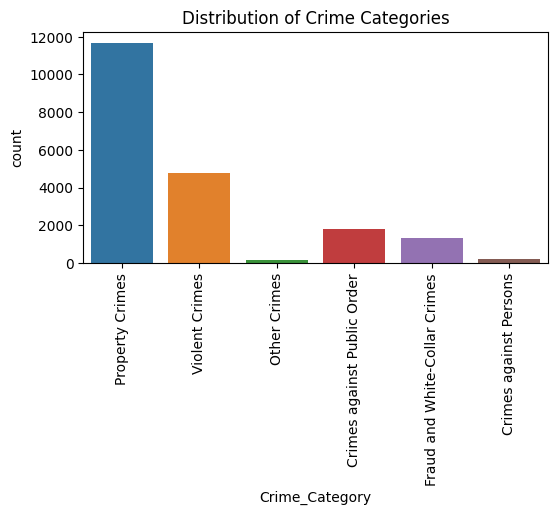

In [16]:
# Visualize the distribution of the target variable 'Crime_Category'
plt.figure(figsize=(6, 3))
sns.countplot(x='Crime_Category', data=train_df)
plt.title('Distribution of Crime Categories')
plt.xticks(rotation=90)
plt.show()

Text(0, 0.5, 'Count')

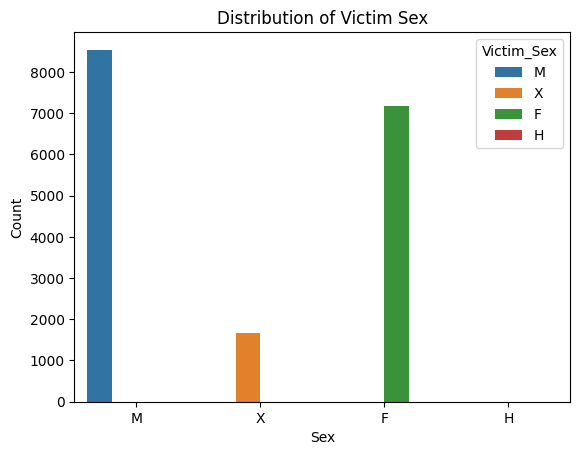

In [17]:
# Vizualize the distribution of victim sex
plt.plot(6, 3)
sns.countplot(x='Victim_Sex', data=train_df, hue = "Victim_Sex")
plt.title('Distribution of Victim Sex')
plt.xlabel('Sex')
plt.ylabel('Count')

# Exploratory Data Analysis (EDA) Summary



 **Columns Description:**

* Location: Street address of the crime incident.
* Cross_Street: Cross street of the rounded address.
* Latitude: Latitude coordinates of the crime incident.
* Longitude: Longitude coordinates of the crime incident.
* Date_Reported: Date the incident was reported.
* Date_Occurred: Date the incident occurred.
* Time_Occurred: Time the incident occurred in 24-hour military time.
* Area_ID: LAPD's Geographic Area number.
* Area_Name: Name designation of the LAPD Geographic Area.
* Reporting_District_no: Reporting district number.
* Part 1-2: Crime classification.
* Modus_Operandi: Activities associated with the suspect.
* Victim_Age: Age of the victim.
* Victim_Sex: Gender of the victim.
* Victim_Descent: Descent code of the victim.
* Premise_Code: Premise code indicating the location of the crime.
* Premise_Description: Description of the premise code.
* Weapon_Used_Code: Weapon code indicating the type of weapon used.
* Weapon_Description: Description of the weapon code.
* Status: Status of the case.
* Status_Description: Description of the status code.
* Crime_Category: The category of the crime (Target Variable)

**Missing Values in Training Data**

The training dataset contains several columns with missing values:

* ***Cross_Street***, ****Modus_Operandi****, ****Weapon_Used_Code****, ****Weapon_Description**** have significant missing values.

* ****Victim_Sex**** and ****Victim_Descent**** have some missing values.

**Distribution of Numerical Features**

The numerical features show varied distributions:

* **Latitude** and **Longitude** have a normal distribution, indicating the geographical spread of the data.

* **Time_Occurred** ranges from 0 to 2359, representing the time in a 24-hour format.

* **Victim_Age** has some anomalies with age values like 0 and -1, which might be indicating null or missing values.

* **Area_ID**, **Reporting_District_no**, **Premise_Code**, and **Weapon_Used_Code** are categorical but encoded as numerical values.

**Categorical Features Analysis**

* **Crime_Category** shows class imbalance, which might affect model performance.

* **Premise_Description** indicates most crimes happen on streets, single-family dwellings, and multi-unit dwellings.

* **Weapon_Description** reveals that "strong-arm" is the most common weapon used.

* **Status** and **Status_Description** show that most cases are marked as "Invest Cont" (Investigation Continued).

* There are more Male victims in **Victim_Sex** than Female victims.

**Target Variable Distribution**

The target variable **Crime_Category** has an imbalanced distribution, with some categories being more frequent than others.

# Data Cleaning

In [18]:
# Separate features and target variable from training data and making a copy of test dataset
X = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]

In [19]:
# Handle missing values
def handle_missing_values(df):
    # Replace invalid ages with NaN
    df['Victim_Age'] = df['Victim_Age'].replace({0: np.nan, -1: np.nan, -2: np.nan})

    # Fill NaN values in categorical columns with 'Unknown'
    categorical_columns = ['Cross_Street', 'Modus_Operandi', 'Victim_Sex', 'Victim_Descent', 'Premise_Description', 'Weapon_Description']
    for column in categorical_columns:
        if column in df.columns:
            df[column] = df[column].fillna('Unknown')

    # Fill missing numerical values with the median values
    if 'Weapon_Used_Code' in df.columns:
        df['Weapon_Used_Code'] = df['Weapon_Used_Code'].fillna(df['Weapon_Used_Code'].median())

    # Fill missing numerical values with the mean values
    if 'Victim_Age' in df.columns:
        df['Victim_Age'] = df['Victim_Age'].fillna(df['Victim_Age'].mean())

    return df

X = handle_missing_values(X)
test_df = handle_missing_values(test_df)

In [20]:
X.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 0)

# Feature Extraction

In [21]:
# Extract Year, Month, Day and Dayofweek from 'Date_Occurred' and 'Date_Reported'
def convert_and_extract_date_features(df):
    format = '%m/%d/%Y %I:%M:%S %p'
    columns = ['Date_Reported', 'Date_Occurred']
    for column in columns:
        df[column] = pd.to_datetime(df[column], format=format)
        df[f'{column}_year'] = df[column].dt.year
        df[f'{column}_month'] = df[column].dt.month
        df[f'{column}_day'] = df[column].dt.day
        df[f'{column}_dayofweek'] = df[column].dt.dayofweek
    df['reporting_delay_days'] = (df['Date_Reported'] - df['Date_Occurred']).dt.days
    df.drop(columns, axis=1, inplace=True)
    return df

X = convert_and_extract_date_features(X)
test_df = convert_and_extract_date_features(test_df)

In [22]:
# Extract hour and minute from 'Time_Occurred'
def extract_time_features(df):
    time_column = 'Time_Occurred'
    df['Hour_Occurred'] = df[time_column].apply(lambda x: int(x // 100) if pd.notna(x) else x)
    df['Minute_Occurred'] = df[time_column].apply(lambda x: int(x % 100) if pd.notna(x) else x)
    df.drop(time_column, axis=1, inplace=True)
    return df

X = extract_time_features(X)
test_df = extract_time_features(test_df)

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Location                 20000 non-null  object 
 1   Cross_Street             20000 non-null  object 
 2   Latitude                 20000 non-null  float64
 3   Longitude                20000 non-null  float64
 4   Area_ID                  20000 non-null  float64
 5   Area_Name                20000 non-null  object 
 6   Reporting_District_no    20000 non-null  float64
 7   Part 1-2                 20000 non-null  float64
 8   Modus_Operandi           20000 non-null  object 
 9   Victim_Age               20000 non-null  float64
 10  Victim_Sex               20000 non-null  object 
 11  Victim_Descent           20000 non-null  object 
 12  Premise_Code             20000 non-null  float64
 13  Premise_Description      20000 non-null  object 
 14  Weapon_Used_Code      


Distribution of Numerical Features:


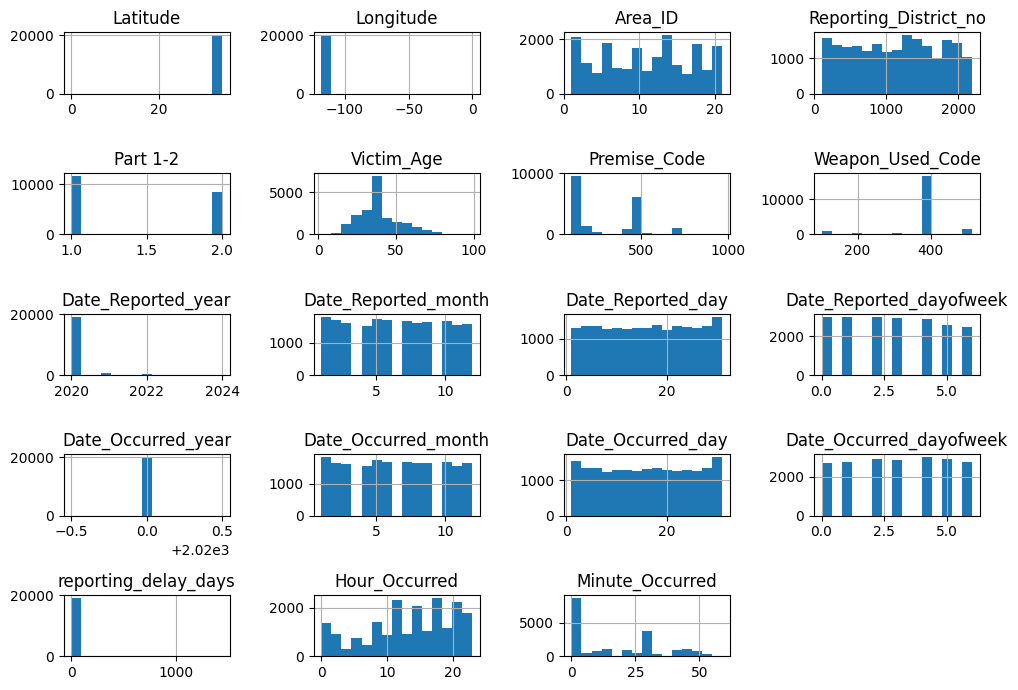

In [24]:
numeric_features = X.select_dtypes(include=['float64', 'int64', 'int32']).columns

print("\nDistribution of Numerical Features:")
X[numeric_features].describe()


# Plot histograms for numerical features
X[numeric_features].hist(bins=15, figsize=(10, 7), layout=(5, 4))
plt.tight_layout()
plt.show()

# Data Preprocessing
> * Numerical Features - Imputing and Scaling
> * Categorical Features - Imputing and Encoding

In [25]:
# Preprocessing pipeline for numerical features
numeric_features = X.select_dtypes(exclude=['object']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [26]:
# Preprocessing pipeline for categorical features
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [27]:
# Combine preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [28]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Model Training

In [29]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

>  **Dummy Classifier**

In [30]:
from sklearn.dummy import DummyClassifier


# Define the model
model_dummy = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DummyClassifier(strategy='most_frequent', random_state=42))])

# Fit the model
model_dummy.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_dummy = model_dummy.predict(X_val)

# Calculate accuracy
accuracy_dummy = accuracy_score(y_val, y_val_pred_dummy)

# Cross-validation score
cv_scores_dummy = cross_val_score(model_dummy, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_score_dummy = cv_scores_dummy.mean()

print("Dummy Classifier Model")
print(f"Validation Accuracy: {accuracy_dummy}")
print(f"Cross-Validation Score: {mean_cv_score_dummy}")


Dummy Classifier Model
Validation Accuracy: 0.57575
Cross-Validation Score: 0.5851875


>  **Decision Tree Classifier**

In [31]:
from sklearn.tree import DecisionTreeClassifier

# Define the model
model_dt = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier(random_state=42))])

# Fit the model
model_dt.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_dt = model_dt.predict(X_val)

# Calculate accuracy
accuracy_dt = accuracy_score(y_val, y_val_pred_dt)

# Cross-validation score
cv_scores_dt = cross_val_score(model_dt, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_score_dt = cv_scores_dt.mean()

print("Decision Tree Model")
print(f"Validation Accuracy: {accuracy_dt}")
print(f"Cross-Validation Score: {mean_cv_score_dt}")

Decision Tree Model
Validation Accuracy: 0.85425
Cross-Validation Score: 0.8553125000000001


> **GradientBoostingClassifier**

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the model
model_gb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', GradientBoostingClassifier(random_state=42))])

# Fit the model
model_gb.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_gb = model_gb.predict(X_val)

# Calculate accuracy
accuracy_gb = accuracy_score(y_val, y_val_pred_gb)

# Cross-validation score
cv_scores_gb = cross_val_score(model_gb, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_score_gb = cv_scores_gb.mean()

print("Gradient Boosting Model")
print(f"Validation Accuracy: {accuracy_gb}")
print(f"Cross-Validation Score: {mean_cv_score_gb}")


Gradient Boosting Model
Validation Accuracy: 0.889
Cross-Validation Score: 0.8838750000000001


> **SVM**

In [33]:
# SVM Model
model_svm = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC(random_state=42))])

# Fit the model
model_svm.fit(X_train, y_train)

# Predict on validation data
y_val_pred_svm = model_svm.predict(X_val)

# Calculate accuracy
accuracy_svm = accuracy_score(y_val, y_val_pred_svm)

# Cross-validation score
cv_scores_svm = cross_val_score(model_svm, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_score_svm = cv_scores_svm.mean()

print("SVM Model")
print(f"Validation Accuracy: {accuracy_svm}")
print(f"Cross-Validation Score: {mean_cv_score_svm}")


SVM Model
Validation Accuracy: 0.8715
Cross-Validation Score: 0.8656874999999999


> **K Neighbors Classifier**

In [34]:
# KNN Model
model_knn = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', KNeighborsClassifier())])

# Fit the model
model_knn.fit(X_train, y_train)

# Predict on validation data
y_val_pred_knn = model_knn.predict(X_val)

# Calculate accuracy
accuracy_knn = accuracy_score(y_val, y_val_pred_knn)

# Cross-validation score
cv_scores_knn = cross_val_score(model_knn, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_score_knn = cv_scores_knn.mean()

print("KNN Model")
print(f"Validation Accuracy: {accuracy_knn}")
print(f"Cross-Validation Score: {mean_cv_score_knn}")


KNN Model
Validation Accuracy: 0.804
Cross-Validation Score: 0.7917500000000001


# **Hyperparameter tuning**

1. **XGBoost Classifier**
2. **SVM**

>  **Hyperparameter Tuned XGBoost Classifier**

In [35]:
# Define the model
model_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))])
# Define a more comprehensive parameter grid for hyperparameter tuning
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}
# GridSearchCV for hyperparameter tuning
grid_search_xgb = GridSearchCV(model_xgb, param_grid_xgb, cv=3, n_jobs=-1, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

# Best parameters and score from GridSearchCV
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

# Evaluate the model on the validation set
y_val_pred_xgb = grid_search_xgb.predict(X_val)

# Calculate cross-validation score on the training set
cv_scores_xgb = cross_val_score(grid_search_xgb.best_estimator_, X_train, y_train, cv=3, scoring='accuracy')
mean_cv_score_xgb = cv_scores_xgb.mean()

print("Hyperparameter Tuned XGBoost Classifier Model")
print("Best Parameters:", best_params_xgb)
print("Best CV Score during tuning:", best_score_xgb)
print("Cross-Validation Score after tuning:", mean_cv_score_xgb)

Hyperparameter Tuned XGBoost Classifier Model
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200}
Best CV Score during tuning: 0.8893123194590363
Cross-Validation Score after tuning: 0.8893123194590363


> **Hyperparameter Tuned SVM**

In [36]:
# Hpertuned SVM
# Define the model

model_svm = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC(random_state=42))])
# Define parameter grid for hyperparameter tuning
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}
# GridSearchCV for hyperparameter tuning
grid_search_svm = GridSearchCV(model_svm, param_grid_svm, cv=3, n_jobs=-1, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)
# Best parameters and score from GridSearchCV
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_
# Evaluate the model on the validation set
y_val_pred_svm = grid_search_svm.predict(X_val)

#Calculate cross-validation score on the training set
cv_scores_svm = cross_val_score(grid_search_svm.best_estimator_, X_train, y_train, cv=3, scoring='accuracy')
mean_cv_scores_svm= cv_scores_svm.mean()

print("Hyperparameter Tuned SVM Model")
print("Best Parameters: ",best_params_svm) 
print("Best CV scoring during tuning",best_score_svm)
print(" CV Score after tuning", mean_cv_scores_svm)


Hyperparameter Tuned SVM Model
Best Parameters:  {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best CV scoring during tuning 0.8793751240498651
 CV Score after tuning 0.8793751240498651


# Summary & Insights

> **Data Preprocessing**
> *  **Handling Missing Values:** Imputed with strategies like constant and most_frequent.
> *  **Datetime Conversion:** Extracted hour and minute from Time_Occurred.
> *  **Encoding:** Applied LabelEncoder for the target variable and OneHotEncoder for categorical features.

> **Model Training and Evaluation**
> 
> **Baseline Model**
> 
>     1. Dummy Classifier:
>        * Validation Accuracy: 0.57575
>        * Cross-Validation Score: 0.5851875
> 
> **Advanced Models**
> 
>     2. Decision Tree:
>         * Validation Accuracy: 0.8542
>         * Cross-Validation Score: 0.8553         
>         
>     3. Gradient Boosting Classifier:
>         * Validation Accuracy: 0.8890
>         * Cross-Validation Score: 0.8838
>         
>     4. Support Vector Machine (SVM):
>         * Validation Accuracy: 0.8715
>         * Cross-Validation Score: 0.8656
> 
>     5. K-Nearest Neighbors (KNN):
>         * Validation Accuracy: 0.804
>         * Cross-Validation Score: 0.7917
> 
> **Hyperparameter Tuned Models**
> 
>     1. XGBoost Classifier:
>         * Best Parameters: {'classifier__subsample': 1.0, 'classifier__n_estimators': 200, 'classifier__max_depth': 6}
>         * Best CV Score during tuning: 0.8893
>         * Cross-Validation Score after tuning: 0.8893
> 
>     2. Support Vector Machine (SVM):
>         * Best Parameters: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
>         * Best CV Score during tuning: 0.8793
>         * Cross-Validation Score after tuning: 0.8793

> # Conclusion
> 1. The XGBoost Classifier with hyperparameter tuning achieved the best performance.
> 2. Decision Tree also performed well but was slightly less accurate.
> 3. Gradient Boosting provided good results, demonstrating their effectiveness in handling class imbalance.
> 4. Dummy Classifier served as a baseline, indicating the necessity of more sophisticated models.

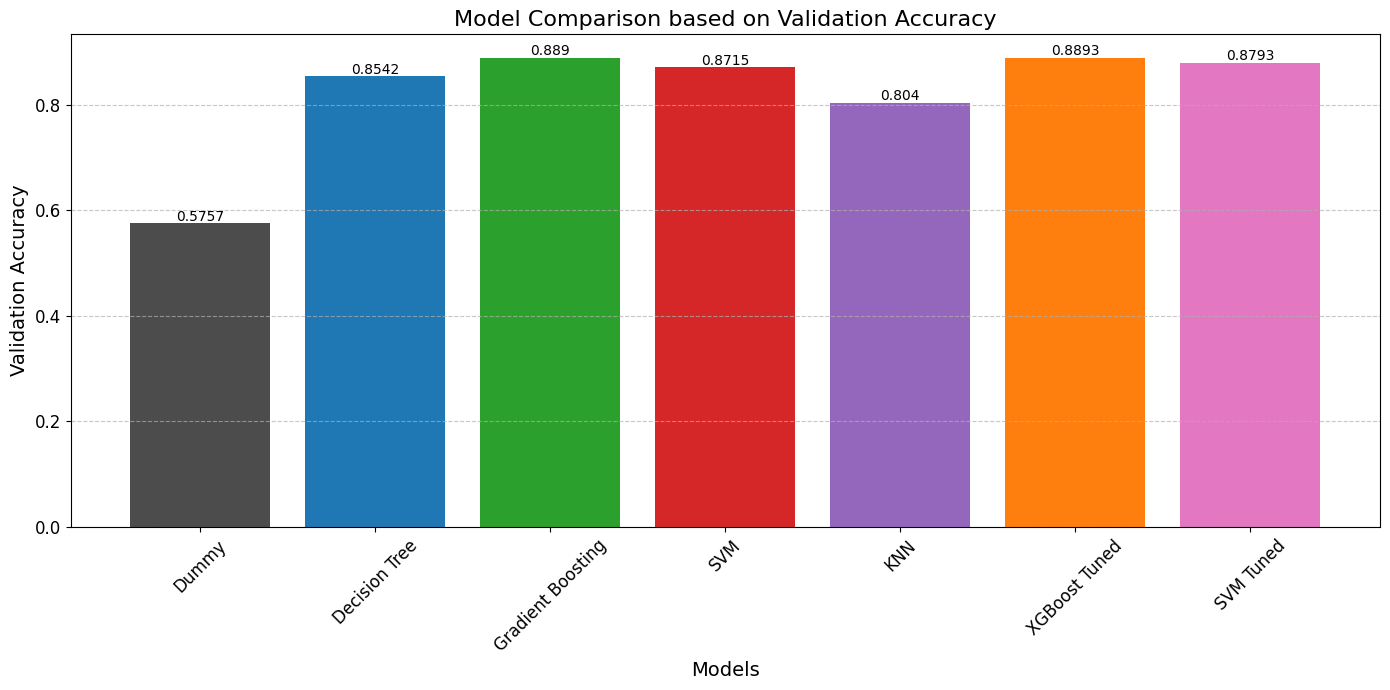

In [37]:
import matplotlib.pyplot as plt

# Validation Accuracy
models = [
    'Dummy', 'Decision Tree', 'Gradient Boosting', 
    'SVM', 'KNN', 'XGBoost Tuned', 
    'SVM Tuned'
]

validation_accuracies = [0.5757, 0.8542, 0.8890, 0.8715, 0.8040, 0.8893, 0.8793]

plt.figure(figsize=(14, 7))

# Plotting validation accuracies
bars = plt.bar(models, validation_accuracies, color=[
    '#4c4c4c', '#1f77b4', '#2ca02c', '#d62728', 
    '#9467bd', '#ff7f0e', '#e377c2'
])

# Adding labels and title
plt.xlabel('Models', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.title('Model Comparison based on Validation Accuracy', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding accuracy values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 4), 
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [38]:
# Function to create submission file
def create_submission(model, filename):
    X_test = test_df.copy()
    y_test_pred = model.predict(X_test)
    y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)
    submission = pd.DataFrame({
        "ID": np.arange(1, len(y_test_pred) + 1),
        "Crime_Category": y_test_pred_decoded
    })
    submission.to_csv(filename, index=False)

# Create submission file
create_submission(grid_search_xgb, "submission.csv")

